___
# <font color= #d4b1e6> **Laboratorio 2: Skip-gram vs CBOW – Word Embeddings from Scratch** </font>
- <Strong> Nombre de los integrantes: </Strong>  <font color="blue">`Sarah Lucía Beltrán, Priscila Cervantes Ramírez, Mónica Ibarra Herrera` </font>
- <Strong> Materia: </Strong>  <font color="blue">`Minería de Textos` </font>
___

### <font color= #d4b1e6> **Introducción** </font> 

En este proyecto se implementan y comparan los modelos Skip-gram y CBOW, dos métodos fundamentales para la generación de word embeddings. Estos modelos permiten representar palabras en vectores numéricos que capturan su significado y relaciones semánticas dentro de un texto. El objetivo es comprender su funcionamiento desde cero, analizar sus diferencias y evaluar cuál ofrece mejores resultados en la representación del lenguaje.

### <font color= #d4b1e6> **Librerías** </font> 

In [ ]:
# Librerías
import re, random, collections, numpy as np
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', font_scale=1.2)

- re → limpieza y normalización de texto.

- collections → conteo de palabras mediante Counter.

- torch → define y entrena los modelos neuronales.

- tqdm → muestra barras de progreso.

- matplotlib y seaborn → grafican los resultados.

- DataLoader y Dataset → organización eficiente de los datos de entrenamiento.

- TSNE (de sklearn) y umap → reducen los embeddings de 100 dimensiones a 2D para visualizarlos.

### <font color= #d4b1e6> **Preprocesamiento** </font> 

In [20]:
def normalize_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

Lo que realiza esta función es que normaliza el texto, en otras palabras, convierte a minúsculas, elimina caracteres, dejarlo todo limpio para que esté listo para entrenar el modelo.

In [21]:
def build_vocab(tokens, min_freq=5, max_vocab=50000):
    freq = collections.Counter(tokens)
    freq = {w:c for w,c in freq.items() if c>=min_freq}
    items = sorted(freq.items(), key=lambda x:x[1], reverse=True)[:max_vocab]
    vocab = {w:i+2 for i,(w,_) in enumerate(items)}  # 0=PAD, 1=UNK
    vocab['<PAD>']=0
    vocab['<UNK>']=1
    inv_vocab = {i:w for w,i in vocab.items()}
    return vocab, inv_vocab

La función crea el vocabulario contando la frecuencia de cada palabra, filtra al igual y asigna un índice numérico a cada palabra.

Con frecuencia mínima de 5 que son palabras que aparecen al menos 5 veces en el texto. Y un vocabulario máximo de 50,000 palabras frecuentes.

In [ ]:
def generate_pairs(tokens, vocab, window_min=2, window_max=5, model='cbow', max_pairs=2000000):
    pairs = []
    unk = vocab['<UNK>']
    N = len(tokens)
    for i, w in enumerate(tokens):
        center = vocab.get(w, unk)
        ws = random.randint(window_min, window_max)
        left = max(0, i-ws)
        right = min(N, i+ws+1)
        context = [vocab.get(tokens[j], unk) for j in range(left, right) if j!=i]
        if not context: continue
        if model=='cbow':
            pairs.append((context, center))
        else:
            for c in context:
                pairs.append(([center], c))
        if len(pairs)>=max_pairs: break
    return pairs

Se generan los pares de entrenamiento dependiendo del modelo, si es CBOW: usa palabras de contexto (predice la palabra objetivo) o Skip-gram: usa la palabra objetivo (predice las palabras de contexto).

El contexto se define por una ventana variable de 2 y 5 palabras a cada lado de la palabra objetivo.

In [23]:
class W2VDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs
    def __len__(self): return len(self.pairs)
    def __getitem__(self, idx): return self.pairs[idx]

def collate_cbow(batch):
    contexts, targets = zip(*batch)
    max_len = max(len(c) for c in contexts)
    ctx = torch.zeros((len(contexts), max_len), dtype=torch.long)
    mask = torch.zeros((len(contexts), max_len), dtype=torch.float32)
    for i,c in enumerate(contexts):
        ctx[i,:len(c)] = torch.tensor(c)
        mask[i,:len(c)] = 1.0
    return ctx, mask, torch.tensor(targets)

def collate_skipgram(batch):
    centers, targets = zip(*batch)
    return torch.tensor([c[0] for c in centers]), torch.tensor(targets)

En 'Word2VecDataset' es la clase que guarda los apres de entrenamiento y para 'collate'(ambas), son funciones que preparan los lotes de datos para el entrenamiento del modelo.

### <font color= #d4b1e6> **Modelos** </font> 

In [24]:
class Word2VecBaseModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=100):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        nn.init.normal_(self.embed.weight, std=0.1)

class CBOWModel(Word2VecBaseModel):
    def __init__(self, vocab_size, embedding_dim=100):
        super().__init__(vocab_size, embedding_dim)
        self.lin = nn.Linear(embedding_dim, vocab_size)
    def forward(self, context, mask):
        e = self.embed(context) * mask.unsqueeze(-1)
        ave = e.sum(1) / mask.sum(1, keepdim=True).clamp(min=1e-6)
        return self.lin(ave)

class SkipGramModel(Word2VecBaseModel):
    def __init__(self, vocab_size, embedding_dim=100):
        super().__init__(vocab_size, embedding_dim)
        self.lin = nn.Linear(embedding_dim, vocab_size)
    def forward(self, center):
        e = self.embed(center)
        return self.lin(e)

La clase base de **Word2VecBaseModel** capa de embeddings y cada palabra del vocabulario se asocia con un vector denso de tamaño `embedding_dim`.

**CBOWModel** promedia los embeddings de las palabras de contexto para predecir la palabra objetivo.

**SkipGramModel** utiliza el embedding de la palabra objetivo para predecir las palabras de contexto.

### <font color= #d4b1e6> **Pipeline completo** </font> 

In [39]:
def run_pipeline(
    text_path,
    model_type='cbow',
    min_freq=5,
    max_vocab=50000,
    embedding_dim=100,
    epochs=5,
    batch_size=1024,
    window_min=2,
    window_max=5,
    N_TOKENS=None,
    MAX_PAIRS=2000000
):
    # 1. Leer y normalizar
    with open(text_path, 'r', encoding='utf-8') as f:
        raw = f.read()
    raw = normalize_text(raw)
    tokens = raw.split()
    if N_TOKENS: tokens = tokens[:N_TOKENS]
    print(f"Tokens cargados: {len(tokens)}")

    # 2. Vocabulario
    vocab, inv_vocab = build_vocab(tokens, min_freq, max_vocab)
    print(f"Vocab size: {len(vocab)}")

    # 3. Generar pares
    pairs = generate_pairs(tokens, vocab, window_min, window_max, model_type, MAX_PAIRS)
    print(f"Pares generados: {len(pairs)}")

    # 4. Dataset y DataLoader
    dataset = W2VDataset(pairs)
    collate_fn = collate_cbow if model_type=='cbow' else collate_skipgram
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Using device:", device)

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn,
                            num_workers=4, pin_memory=True)

    # 5. Modelo, loss, optimizer
    vocab_size = len(vocab)
    model = CBOWModel(vocab_size, embedding_dim).to(device) if model_type=='cbow' else SkipGramModel(vocab_size, embedding_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    # 6. Entrenamiento
    for epoch in range(1, epochs+1):
        model.train()
        tot_loss = 0
        for batch in tqdm(dataloader, desc=f"Epoch {epoch}"):
            optimizer.zero_grad()
            if model_type=='cbow':
                ctx, mask, tgt = batch
                ctx, mask, tgt = ctx.to(device), mask.to(device), tgt.to(device)
                logits = model(ctx, mask)
            else:
                centers, tgt = batch
                centers, tgt = centers.to(device), tgt.to(device)
                logits = model(centers)
            loss = criterion(logits, tgt)
            loss.backward()
            optimizer.step()
            tot_loss += loss.item()*tgt.size(0)
        print(f"Epoch {epoch} avg loss: {tot_loss/len(dataset):.4f}")

    # 7. Extraer embeddings
    embs = model.embed.weight.data.cpu().numpy()

    # 8. Función top-10 similitud coseno
    def topk(anchor, k=10):
        idx = vocab.get(anchor)
        if idx is None:
            print(anchor, "no en vocab")
            return
        norm = embs / (np.linalg.norm(embs,axis=1,keepdims=True)+1e-9)
        sims = norm @ norm[idx].reshape(-1,1)
        sims = sims.squeeze()
        sims[idx] = -1e9
        top = sims.argsort()[::-1][:k]
        print("Top for", anchor, ":", [ (inv_vocab[i], float(sims[i])) for i in top ])

    # 9. Reducción dimensional
    top_words = list(sorted(vocab.items(), key=lambda x:-x[1]))[:500]
    top_idx = [vocab[w] for w,_ in top_words]
    top_embs = embs[top_idx]

    tsne_2d = TSNE(n_components=2, random_state=42).fit_transform(top_embs)
    umap_2d = umap.UMAP(n_components=2, random_state=42).fit_transform(top_embs)

    # 10. Visualización
    def plot_2d(emb_2d, words, title):
        plt.figure(figsize=(14,10))
        plt.scatter(emb_2d[:,0], emb_2d[:,1], s=10)
        for i, w in enumerate(words):
            if i%5==0:  # solo etiqueta algunas para no saturar
                plt.text(emb_2d[i,0], emb_2d[i,1], w, fontsize=9)
        plt.title(title)
        plt.show()

    words_annot = [w for w,_ in top_words]
    plot_2d(tsne_2d, words_annot, f"{model_type.upper()} - t-SNE")
    plot_2d(umap_2d, words_annot, f"{model_type.upper()} - UMAP")

    # 11. Ejemplo top-10 palabras
    for anchor in ['king','man','queen','city']:
        topk(anchor)

    return {
        'model': model,
        'embeddings': embs,
        'vocab': vocab,
        'inv_vocab': inv_vocab
    }

Se hace la lectura y normalización del texto en donde limpia el archivo y lo convierte en una lista de tokens; mapea palabras y elimina las poco frecuentes; se generan pares de entrenamiento; se crean los dataset y dataloader donde se divide en batches para el entrenamiento; se define el modelo, la función de pérdida y el optimizador; se realiza el entrenamiento; la extracción de embeddings; función de `topk` donde calcula las 10 palabras más similares a una palabra dada y de esta manera se muestran las relaciones; se hace la reducción de dimensionalidad y por último la visualización junto con ejemplos de similitud.

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Se accede al archivo de texto almacenando en Google Drive.

In [28]:
ruta_text8 = '/content/drive/MyDrive/text8'

Tokens cargados: 200000
Vocab size: 4535
Pares generados: 500000
Using device: cuda


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1:   0%|          | 0/489 [00:00<?, ?it/s]

Epoch 1 avg loss: 6.7708


Epoch 2:   0%|          | 0/489 [00:00<?, ?it/s]

Epoch 2 avg loss: 5.8960


Epoch 3:   0%|          | 0/489 [00:00<?, ?it/s]

Epoch 3 avg loss: 5.8289


Epoch 4:   0%|          | 0/489 [00:00<?, ?it/s]

Epoch 4 avg loss: 5.7783


Epoch 5:   0%|          | 0/489 [00:00<?, ?it/s]

Epoch 5 avg loss: 5.7295


Epoch 6:   0%|          | 0/489 [00:00<?, ?it/s]

Epoch 6 avg loss: 5.6823


Epoch 7:   0%|          | 0/489 [00:00<?, ?it/s]

Epoch 7 avg loss: 5.6368


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


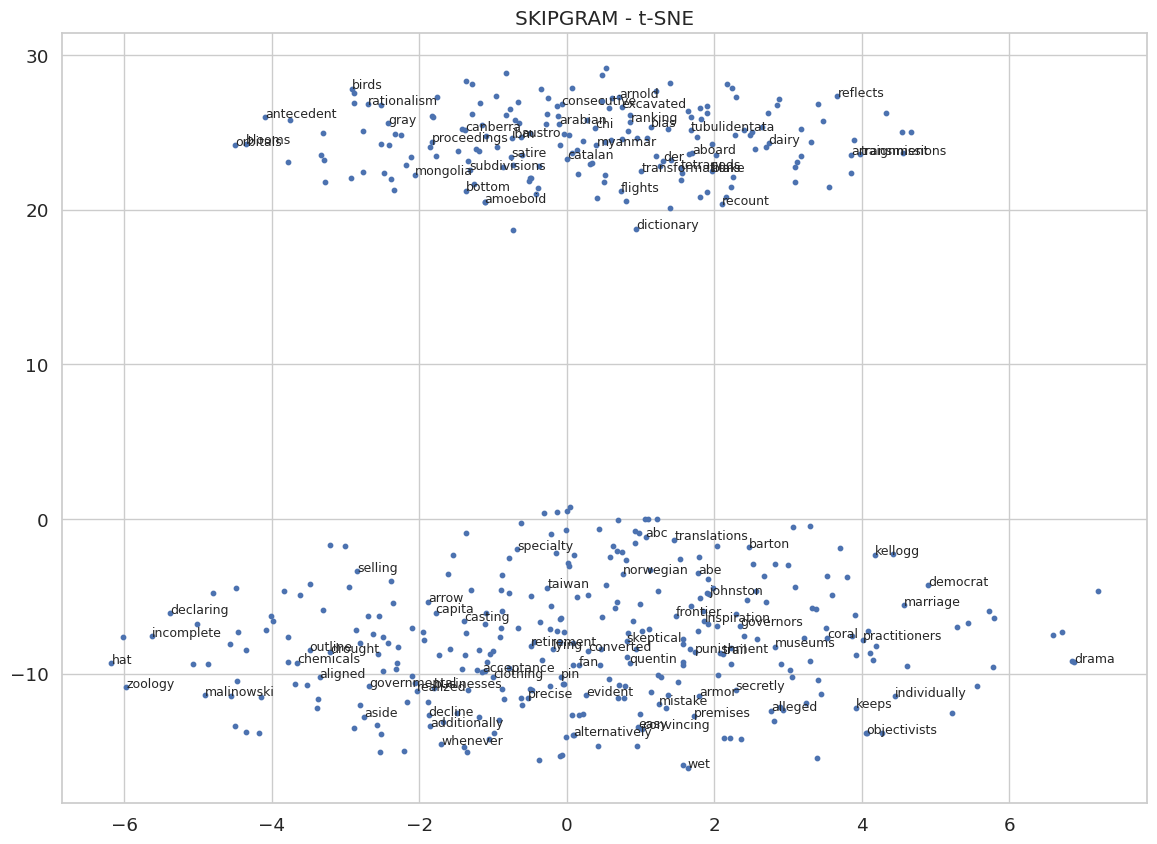

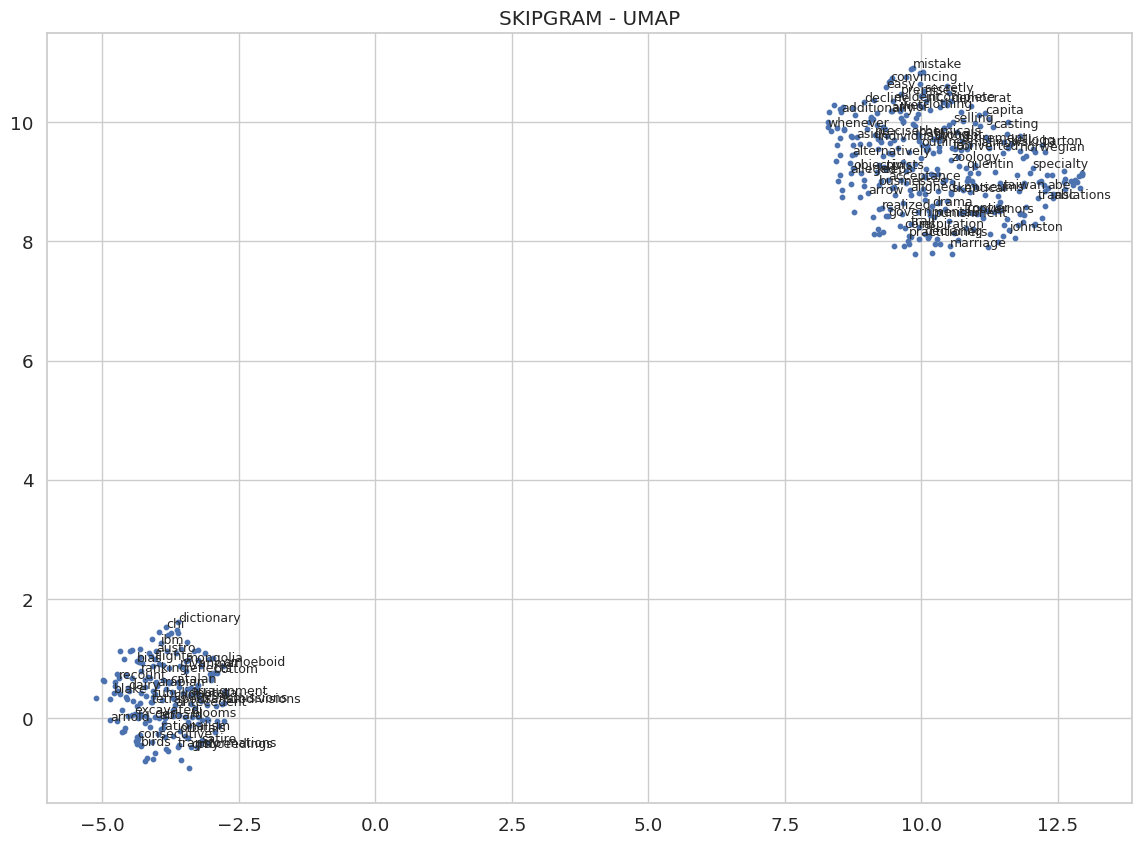

Top for king : [('village', 0.7303355932235718), ('peninsula', 0.7197621464729309), ('jacques', 0.6964287757873535), ('portrayal', 0.6906852722167969), ('bishop', 0.6888039708137512), ('lakes', 0.6830700635910034), ('thirteen', 0.6797162890434265), ('trail', 0.6773689985275269), ('dollar', 0.6773062348365784), ('location', 0.6771302223205566)]
Top for man : [('question', 0.6705831289291382), ('accidentally', 0.653157651424408), ('sphere', 0.6413782835006714), ('passage', 0.6406323909759521), ('fertile', 0.6382513642311096), ('said', 0.6321243643760681), ('promise', 0.6318159699440002), ('implemented', 0.6283233761787415), ('stopped', 0.6245031356811523), ('favor', 0.6242736577987671)]
Top for queen : [('thirteen', 0.7003744840621948), ('roughly', 0.6910967826843262), ('assistance', 0.6907974481582642), ('entertainment', 0.6903727054595947), ('oral', 0.6899053454399109), ('budget', 0.689158022403717), ('export', 0.6884239912033081), ('ceremony', 0.6825323700904846), ('fisher', 0.6781838

In [45]:
result_skip = run_pipeline(
    text_path=ruta_text8,
    model_type='skipgram',  # << aquí cambia
    epochs=7,
    batch_size=1024,
    window_min=2,
    window_max=5,
    N_TOKENS=200000,
    MAX_PAIRS=500000
)

Se ejecuta el pipline dos veces, este con **Modelo Skip-gram**

Tokens cargados: 200000
Vocab size: 4535
Pares generados: 200000
Using device: cuda


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1 avg loss: 7.3737


Epoch 2:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2 avg loss: 6.0605


Epoch 3:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3 avg loss: 5.9176


Epoch 4:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4 avg loss: 5.8321


Epoch 5:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5 avg loss: 5.7623


Epoch 6:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6 avg loss: 5.6929


Epoch 7:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7 avg loss: 5.6237


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


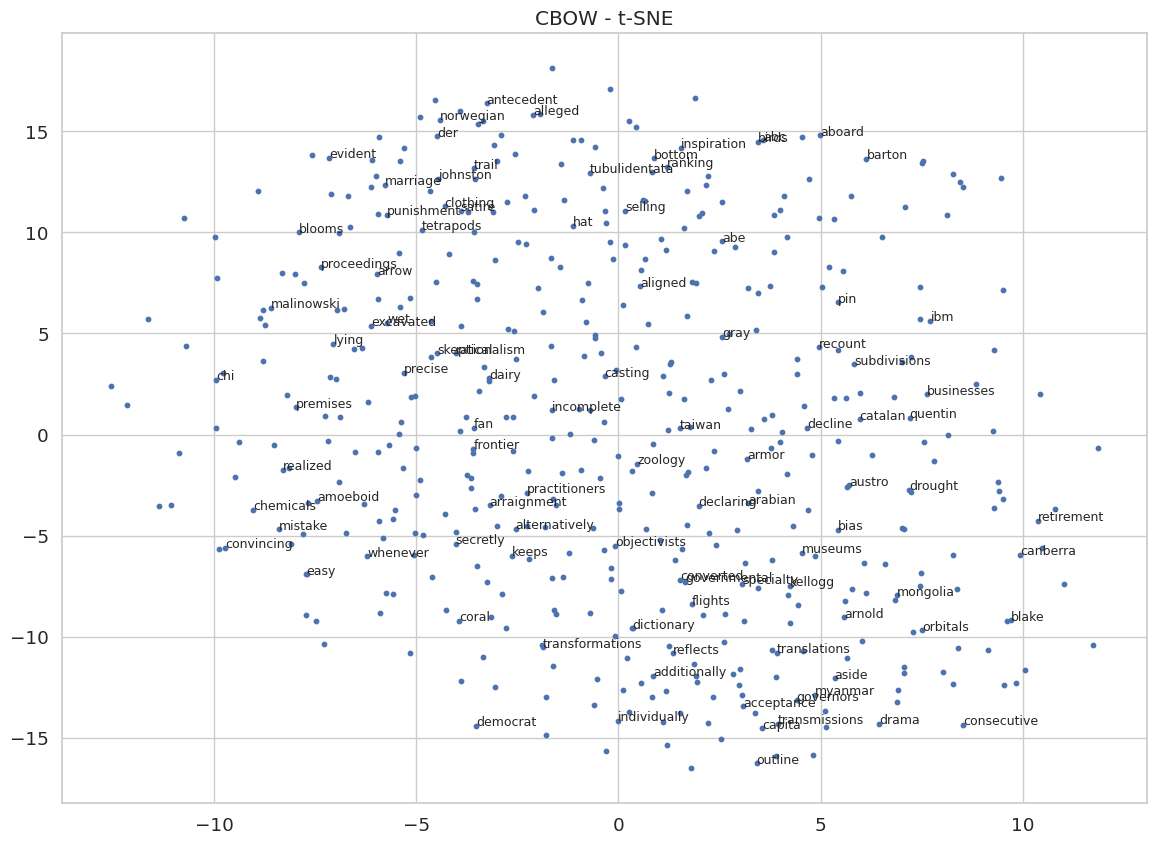

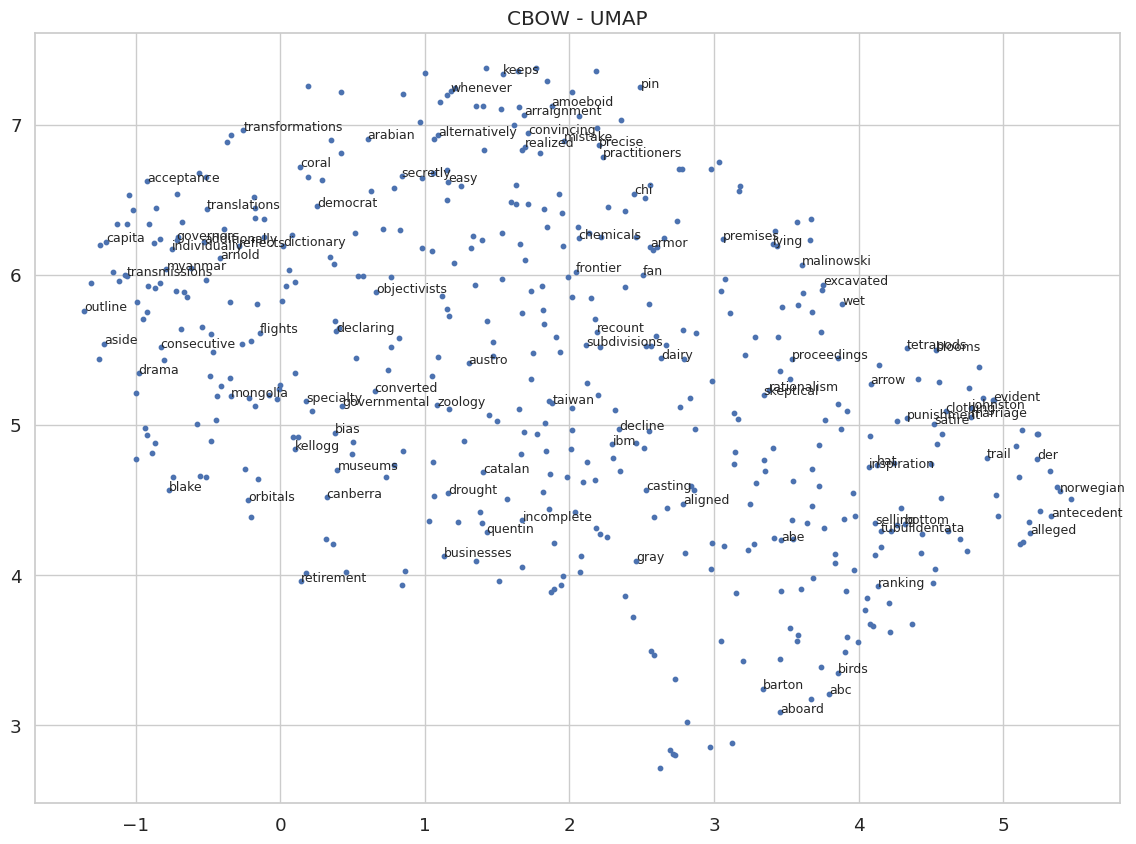

Top for king : [('kings', 0.8313129544258118), ('von', 0.8255606889724731), ('daughter', 0.8248940706253052), ('essay', 0.8113936185836792), ('corpus', 0.8036651611328125), ('peter', 0.803128719329834), ('marsyas', 0.8022118806838989), ('stalin', 0.7995463609695435), ('prophecy', 0.7986220121383667), ('kind', 0.7973331809043884)]
Top for man : [('condition', 0.8278180360794067), ('worked', 0.8252316117286682), ('prefix', 0.7972341775894165), ('answer', 0.7930732369422913), ('job', 0.7927937507629395), ('elected', 0.7916032671928406), ('manner', 0.7891899943351746), ('greeks', 0.7877851128578186), ('claims', 0.7856360673904419), ('symbol', 0.7850124835968018)]
Top for queen : [('suez', 0.8412089347839355), ('creation', 0.8407846689224243), ('content', 0.8312537670135498), ('head', 0.8253136277198792), ('cult', 0.8233474493026733), ('unique', 0.8229646682739258), ('owner', 0.8222256898880005), ('electric', 0.8211017847061157), ('humanities', 0.820064902305603), ('egyptians', 0.8193436264

In [46]:
result_cbow = run_pipeline(
    text_path=ruta_text8,
    model_type='cbow',  # << aquí cambia
    epochs=7,
    batch_size=1024,
    window_min=2,
    window_max=5,
    N_TOKENS=200000,
    MAX_PAIRS=500000
)

Por último este con **CBOW**

### <font color= #d4b1e6> **Conclusiones** </font> 

Podemos observar que para el modelo de **CBOW** es un modelo más rápido y generaliza bien, sus entardas son las palabras de contexto teniendo las de salida palabras objetivo. En cambio, el modelo de **Skip-gram** es más lento pero da mejores resultados en palabras poco frecuentes, sus entradas son las palabras objetivo y las de salida son las palabras de contexto.